In [49]:
import json
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [50]:
def load_activity(file_path, product_name):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    date_list = [
        datetime.fromisoformat(item['time'].replace("Z", "")).date().isoformat()
        for item in data if product_name in item.get('products', [])
    ]
    return Counter(date_list)

chrome_counts = load_activity('ChromeActivity.json', 'Chrome')
youtube_counts = load_activity('YoutubeActivity.json', 'YouTube')

all_dates = sorted(set(chrome_counts.keys()) | set(youtube_counts.keys()))

df = pd.DataFrame({
    'date': all_dates,
    'chrome_count': [chrome_counts.get(date, 0) for date in all_dates],
    'youtube_count': [youtube_counts.get(date, 0) for date in all_dates]
})

start_date = '2025-01-13'
end_date = '2025-04-13'
df['date'] = pd.to_datetime(df['date'])  
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

df.to_csv('filtered_chrome_youtube.csv', index=False)
df.head()

,date,chrome_count,youtube_count
444,2025-01-13,47,0
445,2025-01-14,80,0
446,2025-01-15,32,0
447,2025-01-16,22,0
448,2025-01-17,1,0


In [51]:
usage_df = pd.read_csv("filtered_chrome_youtube.csv")
usage_df["date"] = pd.to_datetime(usage_df["date"])

with open("event.json", "r") as f:
    events = json.load(f)

event_df = pd.DataFrame(events)
event_df["date"] = pd.to_datetime(event_df["date"])

usage_df["stress_level"] = "Mid"
usage_df = usage_df.merge(event_df[["date", "stress_level"]], on="date", how="left", suffixes=("", "_event"))

usage_df["stress_level"] = usage_df["stress_level_event"].combine_first(usage_df["stress_level"])
usage_df.drop(columns=["stress_level_event"], inplace=True)

usage_df.to_csv("merged_activity.csv", index=False)

/Users/fengshiyu/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


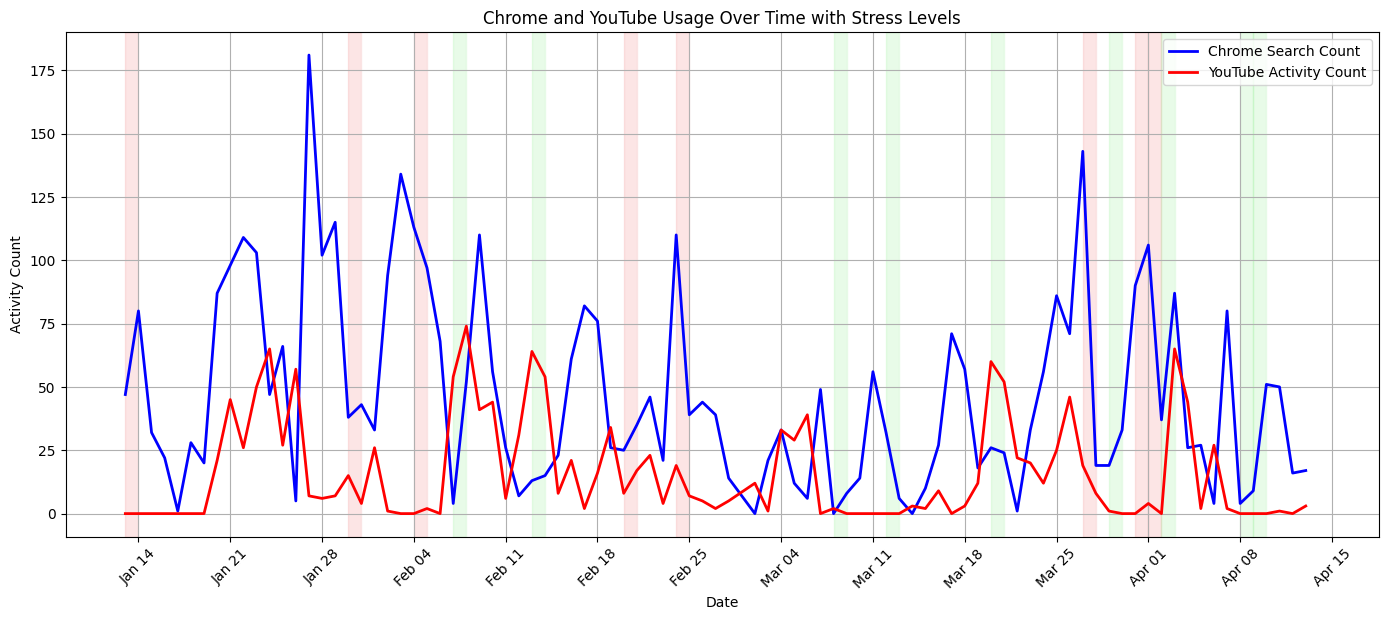

In [52]:
df = pd.read_csv("merged_activity.csv")
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values("date")

plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["chrome_count"], label="Chrome Search Count", color="blue", linewidth=2)
plt.plot(df["date"], df["youtube_count"], label="YouTube Activity Count", color="red", linewidth=2)

stress_colors = {
    "High": "lightcoral",
    "Mid": "white",
    "Low": "lightgreen"
}

for i in range(len(df)):
    plt.axvspan(df["date"].iloc[i], df["date"].iloc[i] + pd.Timedelta(days=1),
                color=stress_colors[df["stress_level"].iloc[i]], alpha=0.2)

plt.title("Chrome and YouTube Usage Over Time with Stress Levels")
plt.xlabel("Date")
plt.ylabel("Activity Count")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xticks(rotation=45)
plt.show()

In [53]:
import seaborn as sns

分组描述统计：
       chrome_count        youtube_count       
              mean median          mean median
label                                         
0             16.0   13.0     20.111111    1.0
1             84.0   98.0      8.125000    6.0


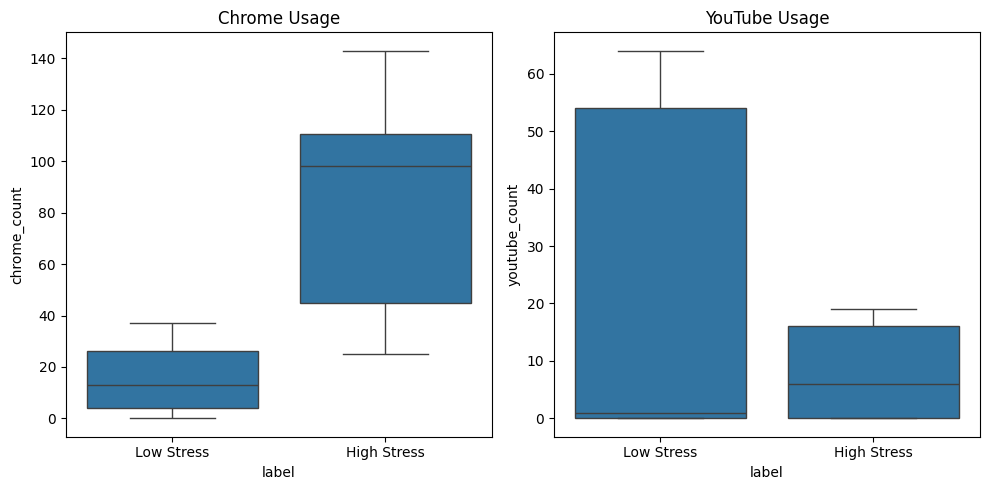

In [54]:
df = pd.read_csv("merged_activity.csv")
df = df[df["stress_level"].isin(["High", "Low"])]
df["label"] = df["stress_level"].map({"Low": 0, "High": 1})

summary = df.groupby("label")[["chrome_count", "youtube_count"]].agg(["mean", "median"])
print("分组描述统计：\n", summary)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x="label", y="chrome_count", data=df)
plt.xticks([0, 1], ['Low Stress', 'High Stress'])
plt.title("Chrome Usage")

plt.subplot(1, 2, 2)
sns.boxplot(x="label", y="youtube_count", data=df)
plt.xticks([0, 1], ['Low Stress', 'High Stress'])
plt.title("YouTube Usage")

plt.tight_layout()
plt.show()

In [55]:
from scipy.stats import ttest_ind

In [56]:
df = pd.read_csv("merged_activity.csv")
df = df[df["stress_level"].isin(["High", "Low"])]
df["label"] = df["stress_level"].map({"Low": 0, "High": 1})

chrome_low = df[df['label'] == 0]['chrome_count']
chrome_high = df[df['label'] == 1]['chrome_count']

youtube_low = df[df['label'] == 0]['youtube_count']
youtube_high = df[df['label'] == 1]['youtube_count']

chrome_t, chrome_p = ttest_ind(chrome_high, chrome_low, equal_var=False)
youtube_t, youtube_p = ttest_ind(youtube_low, youtube_high, equal_var=False)

print(f"Chrome t-test: t = {chrome_t:.2f}, p = {chrome_p:.4f}")
print(f"YouTube t-test: t = {youtube_t:.2f}, p = {youtube_p:.4f}")


Chrome t-test: t = 4.37, p = 0.0022
YouTube t-test: t = 1.17, p = 0.2725


In [57]:
from scipy.stats import pearsonr

In [58]:
r_chrome, p_chrome = pearsonr(df['chrome_count'], df['label'])
r_youtube, p_youtube = pearsonr(df['youtube_count'], df['label'])

print(f"Chrome correlation with stress: r = {r_chrome:.2f}, p = {p_chrome:.4f}")
print(f"YouTube correlation with stress: r = {r_youtube:.2f}, p = {p_youtube:.4f}")

Chrome correlation with stress: r = 0.76, p = 0.0003
YouTube correlation with stress: r = -0.27, p = 0.2866
